In [2]:
import stlearn as st
st.settings.set_figure_params(dpi=120)
import warnings
warnings.filterwarnings('ignore')

## Prepare data

In [3]:
data = st.Read10X(path="/home/d.pham/10X/TBI_C1/")
data.var_names_make_unique()
tmp = data[:,["Fcrls","Tmem119"]].to_df()
microglia_spots = tmp.sum(axis=1)[tmp.sum(axis=1)>1].index

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
import pandas as pd
# Setup list of related and marker genes
upgenes= list(pd.read_table("/home/d.pham/Downloads/up1000.txt",header=None)[0])
downgnees = list(pd.read_table("/home/d.pham/Downloads/down1000.txt",header=None)[0])
merged_upgenes = []
for gene in upgenes:
    if gene in data.var_names:
        merged_upgenes.append(gene)
merged_downgenes = []
for gene in downgnees:
    if gene in data.var_names:
        merged_downgenes.append(gene)
merged_upgenes.append("Fcrls")
merged_upgenes.append("Tmem119")

## Preprocessing

In [5]:
import scanpy as sc
sc.pp.filter_cells(data, min_genes=200)
sc.pp.filter_genes(data, min_cells=3)
data.var['mt'] = data.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(data, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
data = data[data.obs.n_genes_by_counts < 7500, :]


In [6]:
data.raw = data

In [7]:
st.pp.normalize_total(data)
st.pp.log1p(data)

sc.pp.highly_variable_genes(data, min_mean=0.0025, max_mean=3, min_disp=0.5)
data = data[:, data.var.highly_variable]
#sc.pp.regress_out(data, ['total_counts'])

st.pp.scale(data, max_value=10)


Normalization step is finished in adata.X
Log transformation step is finished in adata.X
Scale step is finished in adata.X


## Run stSME

In [8]:
st.em.run_pca(data,n_comps=25,random_state=0)

st.pp.tiling(data,out_path="../tiling",crop_size = data.uns["spatial"]["Visium_LP4_map_C1"]["scalefactors"]["spot_diameter_fullres"])
st.pp.extract_feature(data)
st.spatial.morphology.adjust(data,use_data="X_pca",radius=40,method="mean")

Tiling image:   5%|▍          [ time left: 00:01 ]

PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


Tiling image: 100%|██████████ [ time left: 00:00 ]
Extract feature: 100%|██████████ [ time left: 00:00 ]
Adjusting data:   3%|▎          [ time left: 00:03 ]

The morphology feature is added to adata.obsm['X_morphology']!


Adjusting data: 100%|██████████ [ time left: 00:00 ]

The data adjusted by morphology is added to adata.obsm['X_pca_morphology']


Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 


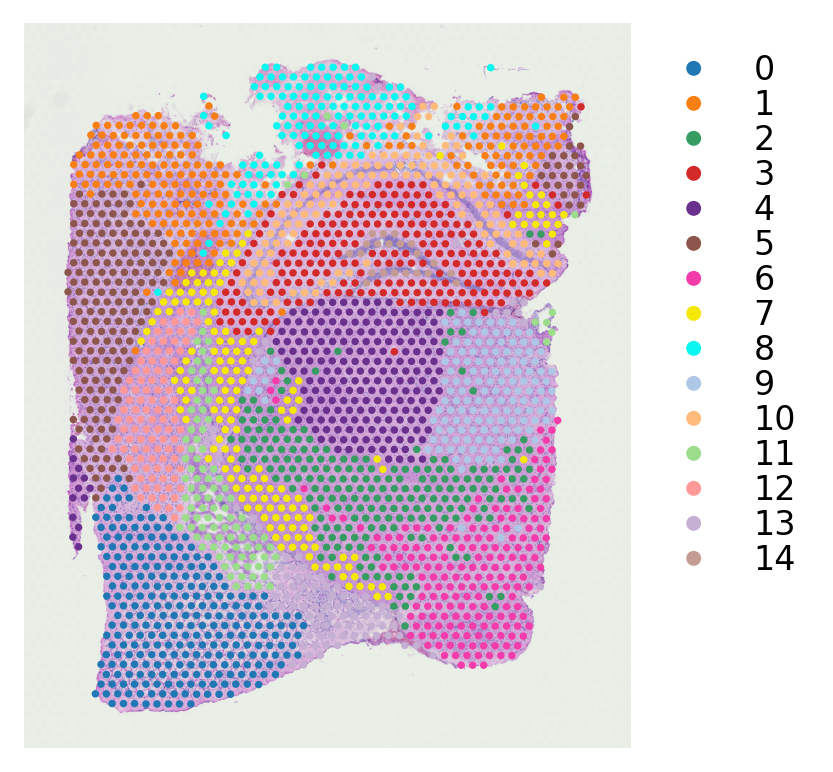

In [9]:
st.settings.set_figure_params(dpi=120)
st.pp.neighbors(data,n_neighbors=25,use_rep='X_pca',random_state=0)
sc.tl.leiden(data,resolution=1,random_state=0)
st.settings.set_figure_params(dpi=120)
st.pl.cluster_plot(data,use_label="leiden")#,output="./",name="cluster_3.png")

## Run Pseudo-time-space

In [10]:
import numpy as np
# Choose root at the edge of cluster 1 (damaged sites)
data.uns["iroot"] = st.spatial.trajectory.set_root(data,use_label="leiden",cluster=1,use_raw=True)
st.spatial.trajectory.pseudotime(data,eps=100,use_label="leiden",threshold_spots=15,use_sme=False,use_rep="X_pca",reverse=True)

... storing 'feature_types' as categorical
... storing 'genome' as categorical


Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 
All available trajectory paths are stored in adata.uns['available_paths'] with length < 4 nodes


In [11]:
# Filter spots
micro_spot_filter = []
for ind in microglia_spots:
    if ind in data.obs_names:
        micro_spot_filter.append(ind)

data = data[micro_spot_filter]

In [12]:
st.spatial.trajectory.pseudotimespace_global(data,use_label="leiden",list_clusters=["1","3","4","6"],)


Screening:   0%|           [ time left: ? ]Trying to set attribute `.uns` of view, copying.
Screening:   1%|           [ time left: 00:15 ]

Screening PTS global graph...


Screening: 100%|██████████ [ time left: 00:00 ]
Calculating: 100%|██████████ [ time left: 00:00 ]


Calculate the graph dissimilarity using Laplacian matrix...
The optimized weighting is: 0.53
Start to construct the trajectory: 6 -> 4 -> 3 -> 1


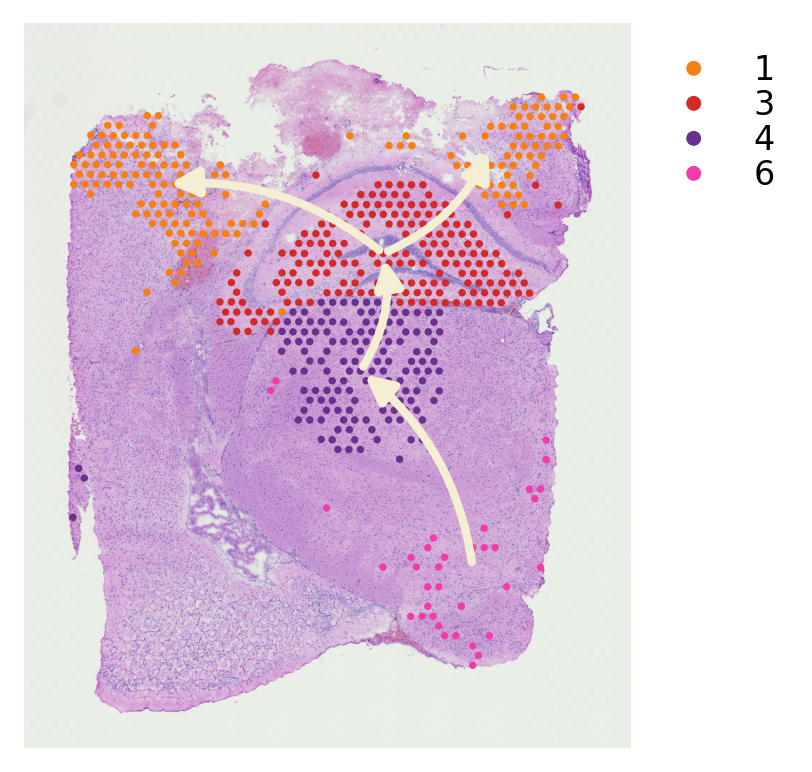

In [13]:
st.pl.cluster_plot(data,use_label="leiden",show_trajectories=True,list_clusters=["1","3","4","6"],show_subcluster=False)

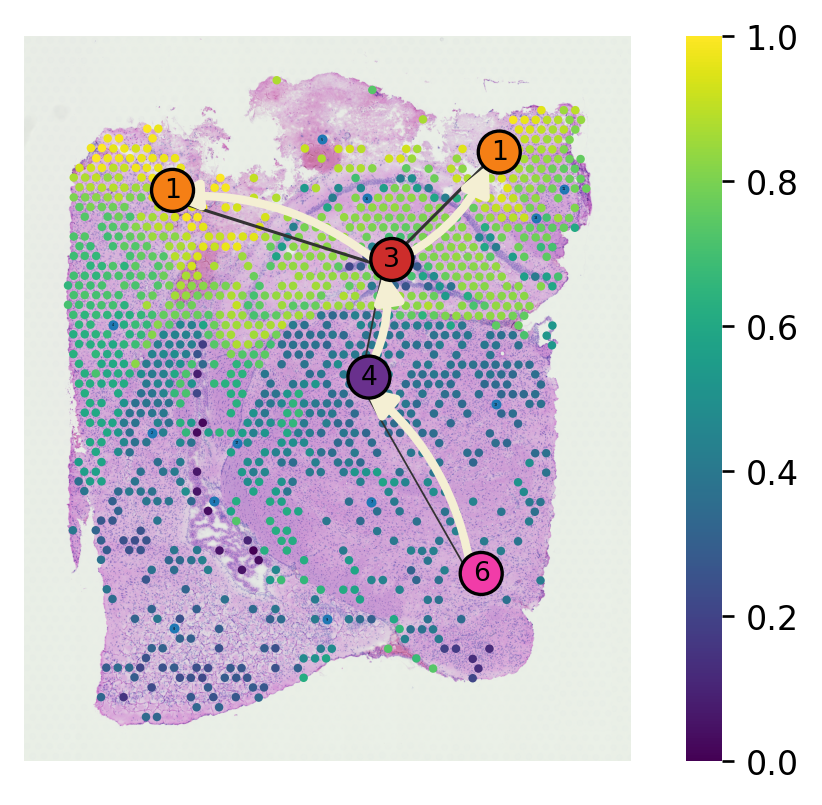

In [15]:
st.pl.trajectory.pseudotime_plot(data,use_label="leiden",list_clusters=["1","3","4","6"],show_graph=True, pseudotime_key="dpt_pseudotime",
                                 edge_alpha=1.0,node_size=7,show_trajectory=True)

PAGA plot:


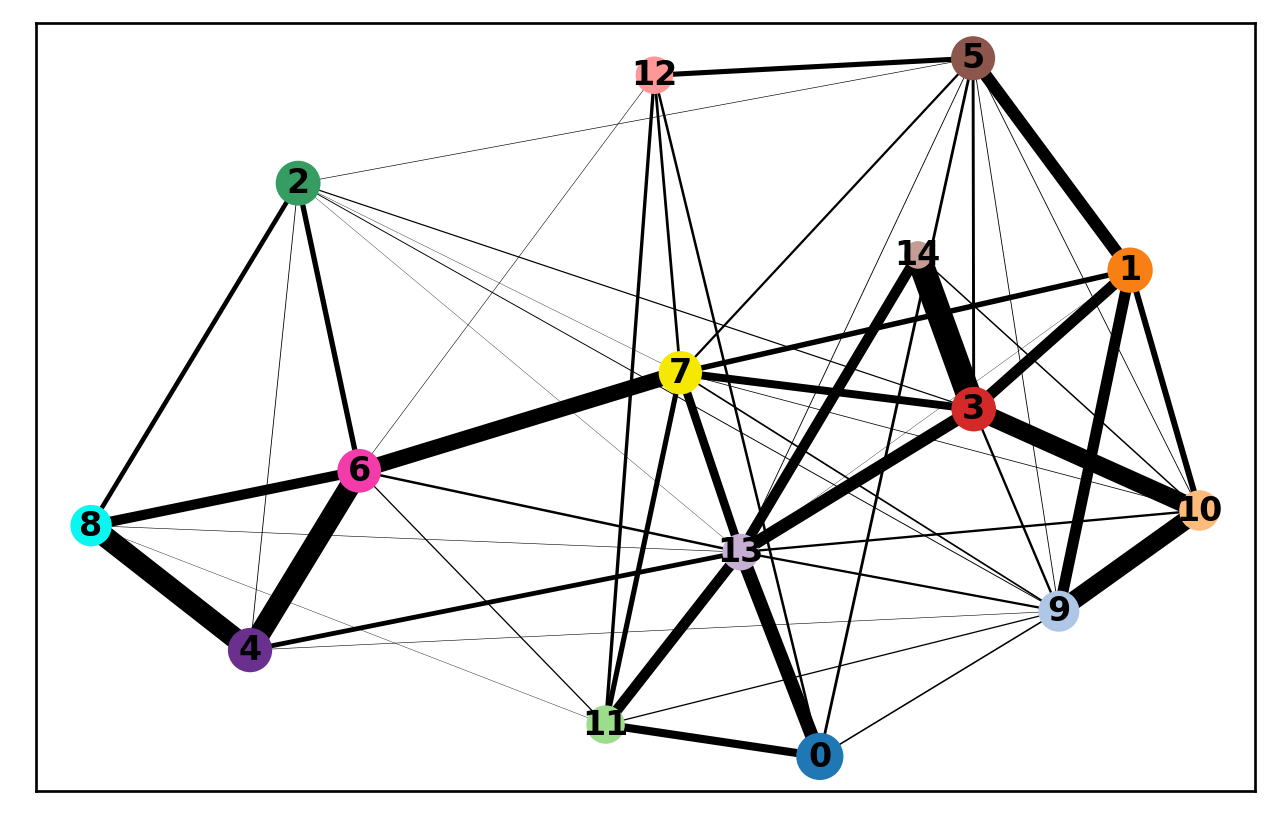

Gene expression (reduced dimension) plot:


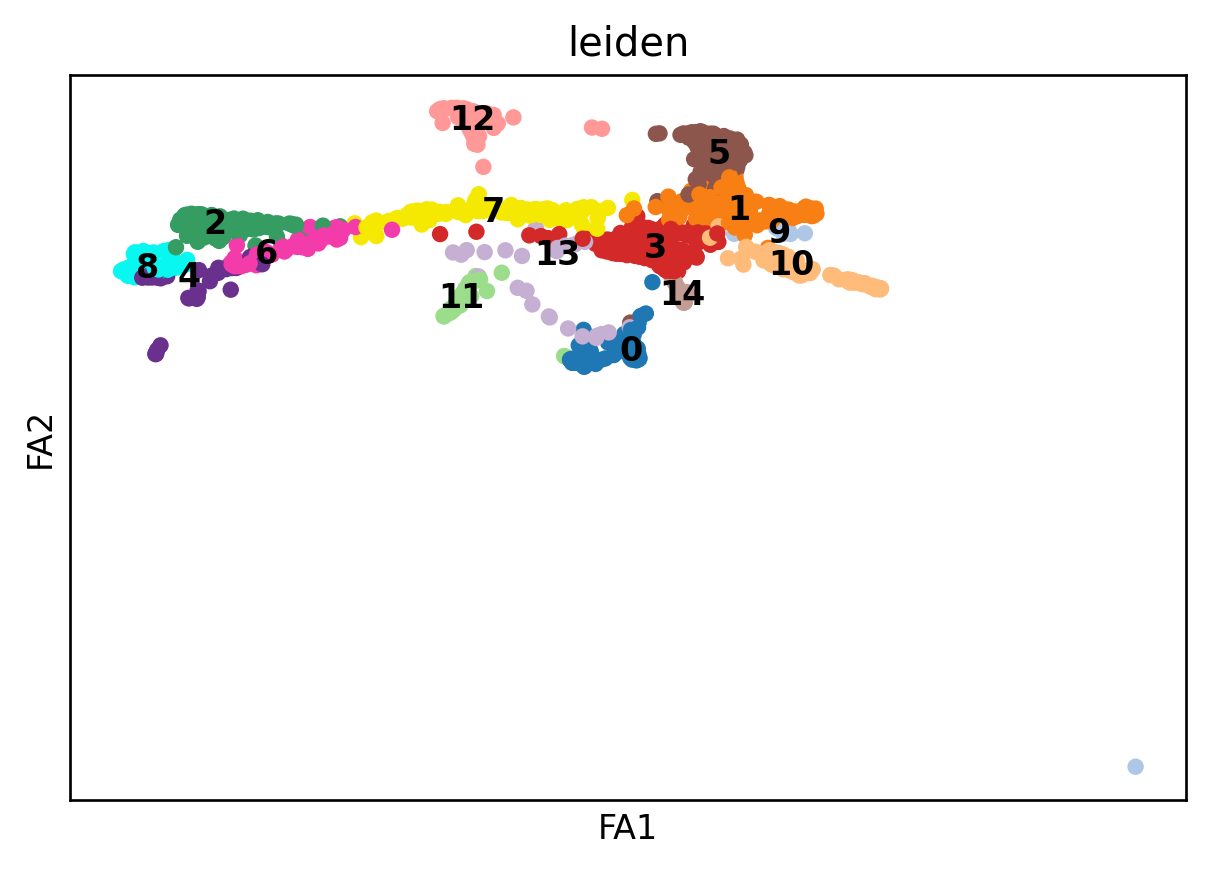

Diffusion pseudotime plot:


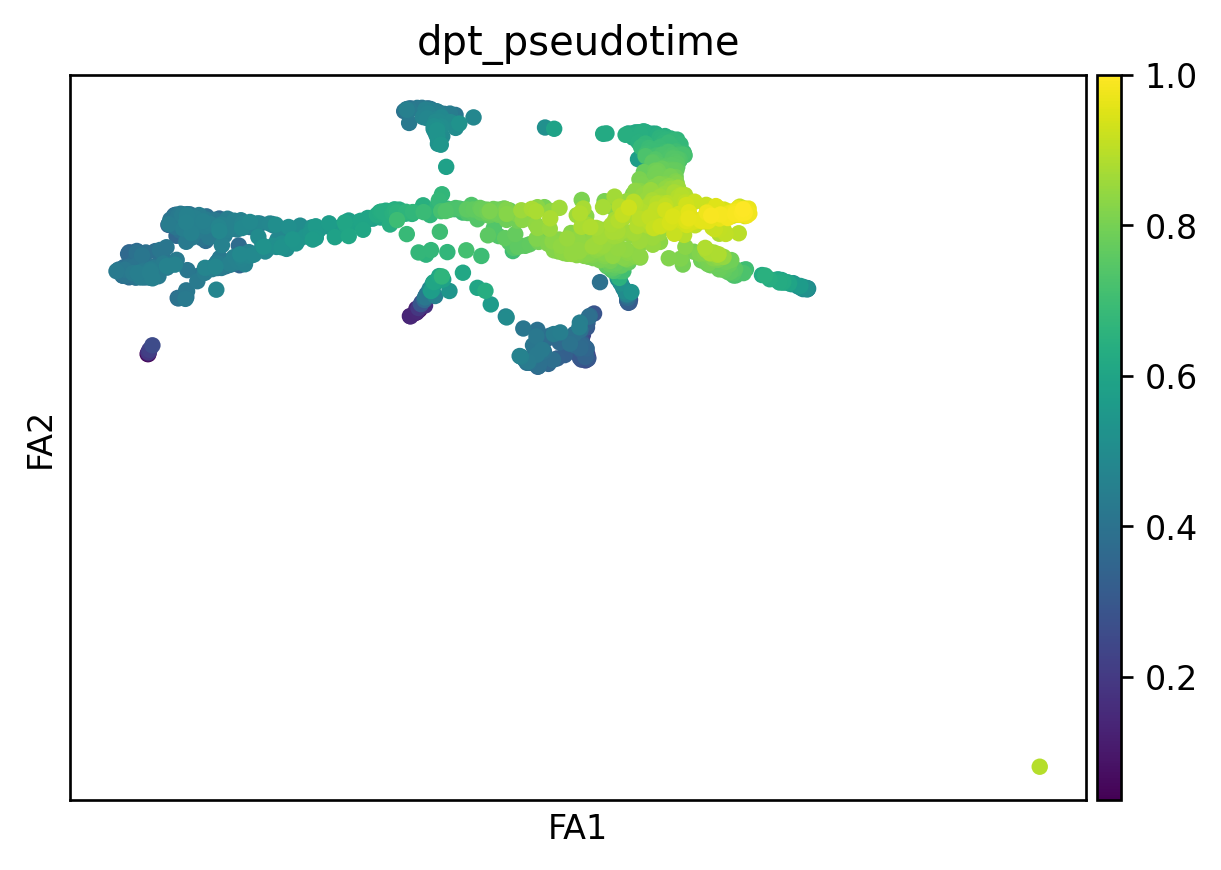

In [19]:
st.pl.non_spatial_plot(data,use_label="leiden")

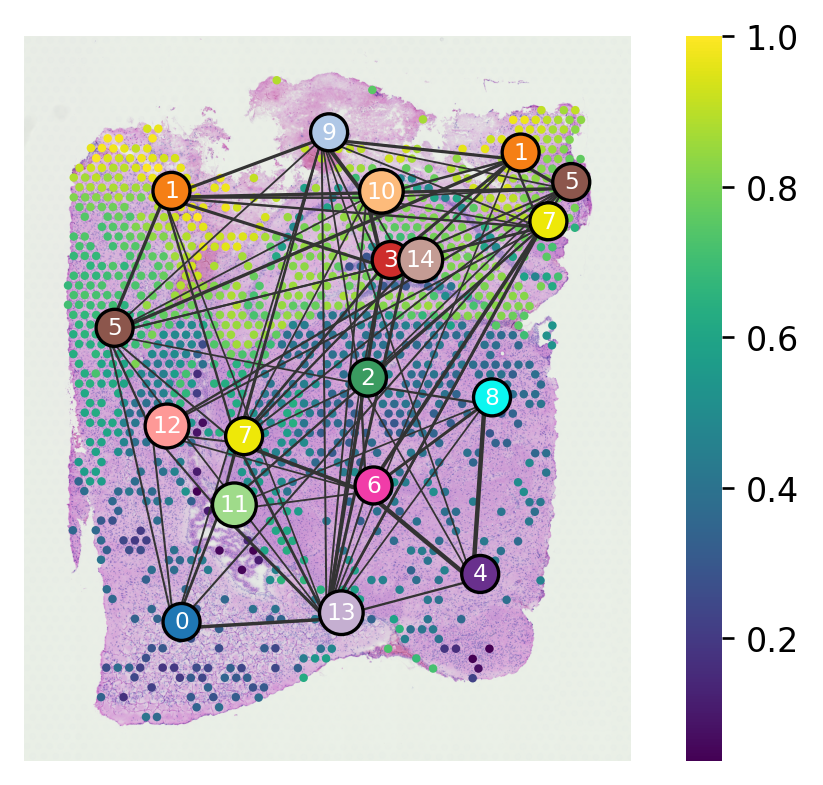

In [50]:
#st.settings.set_figure_params(dpi=300)
st.pl.trajectory.pseudotime_plot(data,use_label="leiden",list_cluster="all",show_graph=True,node_alpha=1,data_alpha=1,edge_alpha=1.0,node_size=7)

## Variogram with Monocle 3

In [16]:
monocle3 = pd.read_csv("../../TBI_analysis/monocle3_pseudotime.csv")

In [23]:
data.obs["dpt_pseudotime"] = list(monocle3.set_index("Unnamed: 0").loc[data.obs_names]["pseudotime(cds)"])

In [24]:
import numpy as np

In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(np.array(data.obs["dpt_pseudotime"]).reshape(-1, 1))

MinMaxScaler()

In [26]:
data.obs["dpt_pseudotime"] = scaler.transform(np.array(data.obs["dpt_pseudotime"]).reshape(-1, 1)).reshape(1, -1)[0]

In [27]:
data.obs["dpt_pseudotime"] = 1 - data.obs["dpt_pseudotime"]

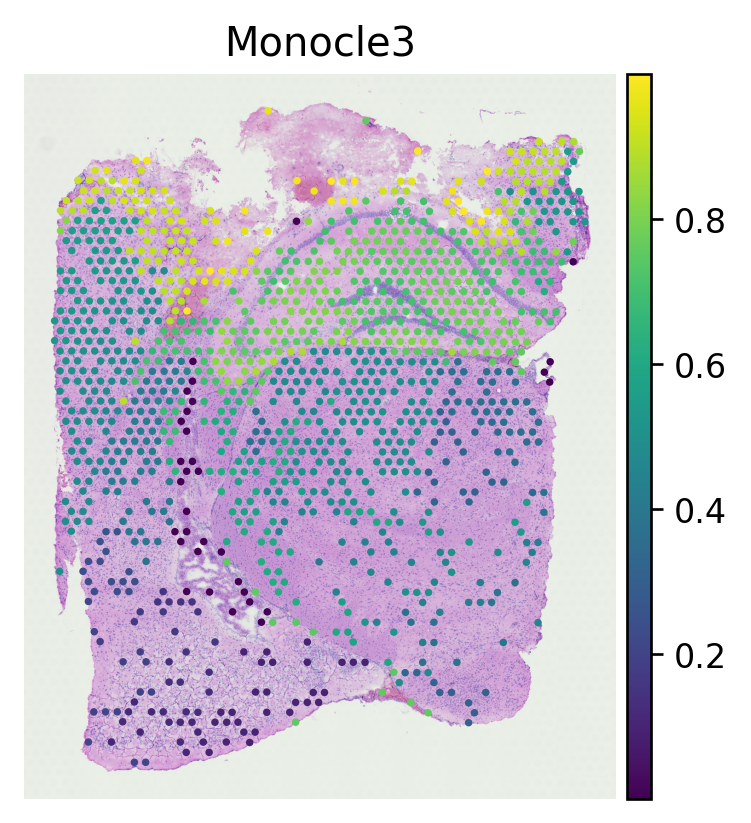

In [37]:
sc.pl.spatial(data,color="dpt_pseudotime",frameon=False,title="Monocle3")

In [30]:
from skgstat import Variogram

In [38]:
V_mor = Variogram(coordinates=data.obs[["imagecol","imagerow"]].values, values=data.obs["dpt_pseudotime"].values,
            model='gaussian')

In [39]:
print(V_mor)

gaussian Variogram
------------------
Estimator:         matheron
Effective Range:   1713.71
Sill:              0.16
Nugget:            0.00
        


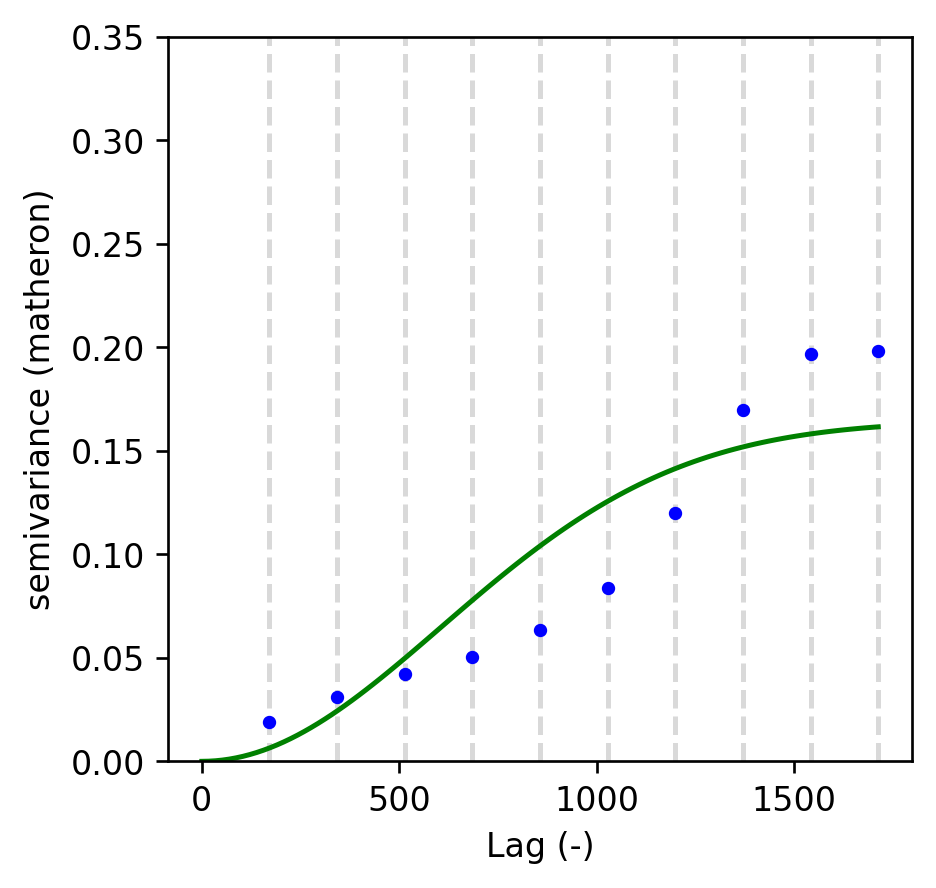

In [41]:
V_mor.plot(hist=False,axes=a)